In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Import Online Retail Data containing transactions.
Rtl_data = pd.read_excel('/Users/dheeraj/Downloads/OnlineRetail.xlsx')


In [7]:
Rtl_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [8]:
Rtl_data.shape

(541909, 8)

## RFM Analysis
RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.
In this notebook I perform RFM analysis on the online retail data set.

In [54]:
#Customer distribution by country
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [55]:
#Keep only United Kingdom data since more than 90% of users are from UK.
Rtl_data = Rtl_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [56]:
#Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [57]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-80995

In [58]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [59]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [60]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [61]:
#Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [62]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
Rtl_data.shape

(354345, 9)

In [63]:
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [64]:
#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
#Amount for each customer
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [65]:
#Descriptive Statistics (Recency)
RFMScores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

/Users/dheeraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



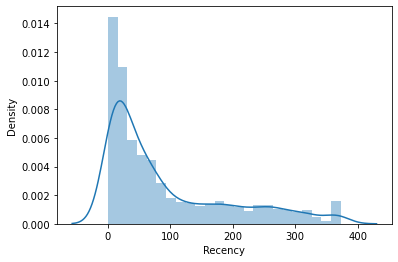

In [66]:
#Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

In [67]:
#Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

/Users/dheeraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



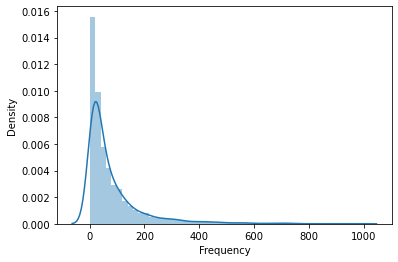

In [68]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x = RFMScores.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [69]:
#Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

/Users/dheeraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



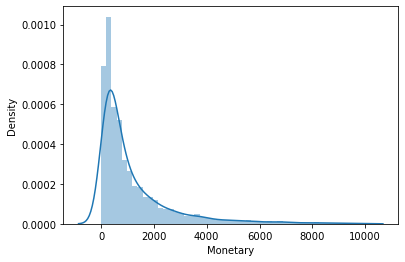

In [70]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
import seaborn as sns
x = RFMScores.query('Monetary < 10000')['Monetary']

ax = sns.distplot(x)

In [71]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [72]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [73]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [74]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [75]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


In [76]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [77]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold','Silver','Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [78]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,Platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,Platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,Platinum


In [79]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

In [80]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Recency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

## Clustering
A cluster refers to a collection of data points aggregated together because of certain similarities. K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. The K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.

In [81]:
#Handle the negative and zero values so as to handle the infinite numbers during the log transformation
def handle_negative_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num

#Apply handle_negative_n_zero function to the Recency and Monetary columns
RFMScores['Recency'] = [handle_negative_n_zero(x) for x in RFMScores.Recency]

RFMScores['Monetary'] = [handle_negative_n_zero(x) for x in RFMScores.Monetary ] 

#Perfrom Log Distribution to bring the data into the normal distributio form.

Log_Df_data = RFMScores[['Recency','Frequency','Monetary']].apply(np.log, axis =1 ).round(3)


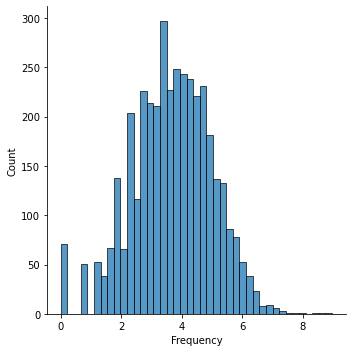

In [82]:
#Data distribution after data normalization for Frequency
Frequency_plot = Log_Df_data.query('Frequency < 1000')['Frequency']
ax = sns.displot(Frequency_plot)

/Users/dheeraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



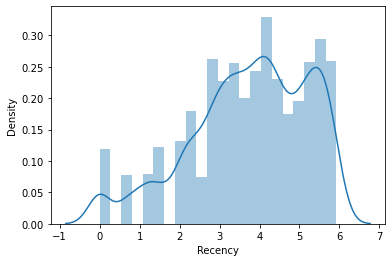

In [83]:
#Data distribution after data normalization for Recency
Recency_plot = Log_Df_data['Recency']
ax = sns.distplot(Recency_plot)

/Users/dheeraj/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



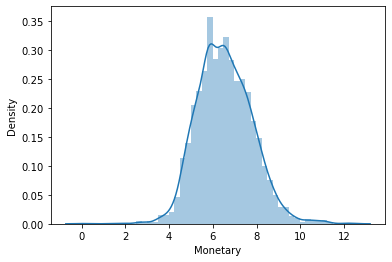

In [84]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Df_data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [88]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Df_data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Df_data.columns)


In [ ]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [90]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2


<Figure size 504x504 with 0 Axes>

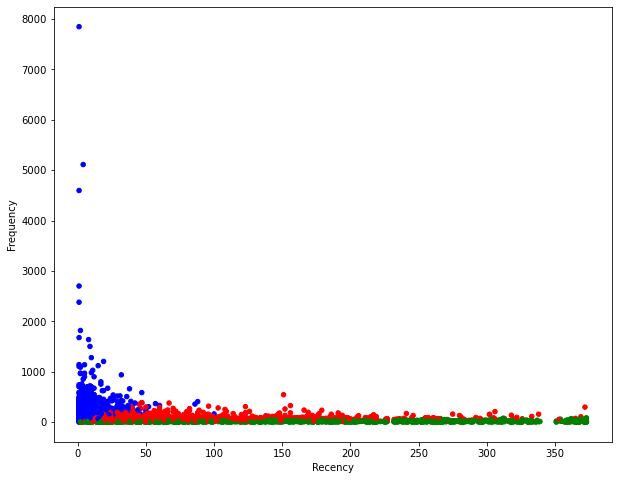

In [91]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)

In [92]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0,red
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,blue
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,blue
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,blue
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,blue


## Conclusion
The above dataframe provides our most loyal customers based on RFMSCORE and classify them into a Loyalty_Level. These results further could be used ion targetted marketing to keep our most loyal customer
engaged by providing some incentive.